In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, auc
from sklearn.metrics import roc_auc_score,precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [2]:
df  = pd.read_csv('dataset/pre_process_all_news_days.csv', encoding = "ISO-8859-1", parse_dates=["Date"])

In [3]:
#Get the name of the headline columns
cols = []
for i in range(1,26):
    col = ("Top{}".format(i))
    cols.append(col)

In [4]:
for col in tqdm(cols):
    df[col] = df[col].apply(lambda x: literal_eval(x))

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


In [6]:
def Evaluation (Method,Comment,Actual, Predicted,Scores):
    ROC_AUC=roc_auc_score(Actual,Predicted)    
    Precision=precision_score(Actual,Predicted)
    Accuracy=accuracy_score(Actual,Predicted)
    Recall=recall_score(Actual,Predicted)
    F1=f1_score(Actual,Predicted)    
    Scores[Comment] = {'Method':Method,'ROC_AUC':ROC_AUC,'Accuracy':Accuracy,
                       'Precision':Precision,'Recall':Recall,'F1':F1}           

In [7]:
#Creating a Data Pipeline for Naive Bayes classifier classifier - baseline
svm_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [8]:
def headlines_analyze(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for cl in cols:    
        df_h['news'] = df[cl]
        train = df_h[df_h['Date']<'20141231']
        test = df_h[df_h['Date']>'20141231']
        y_train = train[lbl]
        y_test = test[lbl]

        svm_pipeline.fit(train['news'],y_train)
        predictions = svm_pipeline.predict(test['news'])    
        Evaluation ('SVC()',cl+'_'+lbl,y_test, predictions,sc)

In [9]:
sc={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze(lbl,sc)

Top9_Label accuracy= 0.5317460317460317


In [16]:
df_sc = pd.DataFrame.from_dict(sc, orient='index')
df_sc.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc.head(10)

,Method,cols,ROC_AUC,Precision,Accuracy,Recall,F1
Top9_Label_1day,SVC(),Top9_Label_1day,0.528226,0.619048,0.534392,0.139785,0.228070
Top12_Label_2day,SVC(),Top12_Label_2day,0.525934,0.722222,0.568783,0.076023,0.137566
Top9_Label,SVC(),Top9_Label,0.525622,0.522388,0.531746,0.911458,0.664137
Top10_Label_2day,SVC(),Top10_Label_2day,0.525044,0.640000,0.566138,0.093567,0.163265
Top25_Label_2day,SVC(),Top25_Label_2day,0.524155,0.593750,0.563492,0.111111,0.187192
Top7_Label_3day,SVC(),Top7_Label_3day,0.520786,0.769231,0.550265,0.056497,0.105263
Top5_Label_2day,SVC(),Top5_Label_2day,0.519832,0.555556,0.558201,0.116959,0.193237
Top7_Label_5day,SVC(),Top7_Label_5day,0.518973,0.666667,0.547619,0.067797,0.123077
Top13_Label_5day,SVC(),Top13_Label_5day,0.516148,0.647059,0.544974,0.062147,0.113402
Top6_Label_4day,SVC(),Top6_Label_4day,0.516033,0.666667,0.547619,0.056818,0.104712


In [17]:
def headlines_analyze_two(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for i in tqdm(range(1,26)):
        col1 = ("Top{}".format(i))
        for j in range(i+1,26):        
            col2 = ("Top{}".format(j))
            cls = col1+'+'+col2             
            df_h['news'] = df[col1]+ df[col2]
            train = df_h[df_h['Date']<'20141231']
            test = df_h[df_h['Date']>'20141231']
            y_train = train[lbl]
            y_test = test[lbl]
            svm_pipeline.fit(train['news'],y_train)
            predictions = svm_pipeline.predict(test['news'])                
            Evaluation ('SVC()',cls+'_'+lbl,y_test, predictions,sc)

In [18]:
sc_2c={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze_two(lbl,sc_2c)

  8%|▊         | 2/25 [00:52<09:56, 25.92s/it]

Top3+Top6_Label accuracy= 0.5317460317460317


 20%|██        | 5/25 [02:02<07:57, 23.86s/it]

Top6+Top12_Label accuracy= 0.5423280423280423
Top6+Top18_Label accuracy= 0.5343915343915344
Top6+Top23_Label accuracy= 0.5423280423280423


 32%|███▏      | 8/25 [03:04<06:01, 21.29s/it]

Top9+Top10_Label accuracy= 0.5343915343915344
Top9+Top16_Label accuracy= 0.5317460317460317


 36%|███▌      | 9/25 [03:21<05:22, 20.14s/it]

Top10+Top20_Label accuracy= 0.5317460317460317


 40%|████      | 10/25 [03:37<04:43, 18.89s/it]

Top11+Top20_Label accuracy= 0.5370370370370371


 60%|██████    | 15/25 [04:42<02:13, 13.32s/it]

Top16+Top18_Label accuracy= 0.5343915343915344


 80%|████████  | 20/25 [05:19<00:38,  7.76s/it]

Top21+Top22_Label accuracy= 0.5343915343915344


100%|██████████| 25/25 [05:29<00:00, 13.19s/it]


In [24]:
df_sc2 = pd.DataFrame.from_dict(sc_2c, orient='index')
df_sc2.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc2.head(10)

,Method,cols,ROC_AUC,Precision,Accuracy,Recall,F1
Top6+Top12_Label_1day,SVC(),Top6+Top12_Label_1day,0.543347,0.833333,0.550265,0.107527,0.190476
Top6+Top23_Label,SVC(),Top6+Top23_Label,0.535786,0.527536,0.542328,0.947917,0.677840
Top6+Top12_Label,SVC(),Top6+Top12_Label,0.535618,0.527221,0.542328,0.958333,0.680222
Top6+Top23_Label_1day,SVC(),Top6+Top23_Label_1day,0.533098,0.687500,0.539683,0.118280,0.201835
Top9+Top16_Label_1day,SVC(),Top9+Top16_Label_1day,0.532930,0.714286,0.539683,0.107527,0.186916
Top21+Top22_Label_1day,SVC(),Top21+Top22_Label_1day,0.532594,0.800000,0.539683,0.086022,0.155340
Top6+Top12_Label_2day,SVC(),Top6+Top12_Label_2day,0.530765,0.812500,0.574074,0.076023,0.139037
Top16+Top18_Label_1day,SVC(),Top16+Top18_Label_1day,0.530494,0.666667,0.537037,0.118280,0.200913
Top11+Top20_Label,SVC(),Top11+Top20_Label,0.530326,0.524355,0.537037,0.953125,0.676525
Top10+Top20_Label_1day,SVC(),Top10+Top20_Label_1day,0.530158,0.720000,0.537037,0.096774,0.170616


In [25]:
def headlines_analyze_three(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for i in tqdm(range(1,26)):
        col1 = ("Top{}".format(i))
        for j in range(i+1,26):        
            col2 = ("Top{}".format(j))
            for k in range(j+1,26):
                col3 = ("Top{}".format(k))
                cls = col1+'+'+col2+'+'+col3
                df_h['news'] = df[col1]+ df[col2]+ df[col3]
                train = df_h[df_h['Date']<'20141231']
                test = df_h[df_h['Date']>'20141231']
                y_train = train[lbl]
                y_test = test[lbl]
                svm_pipeline.fit(train['news'],y_train)
                predictions = svm_pipeline.predict(test['news'])                
                Evaluation ('SVC()',cls+'_'+lbl,y_test, predictions,sc)

In [26]:
sc_3c={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze_three(lbl,sc_3c)

  0%|          | 0/25 [00:00<?, ?it/s]

Top1+Top9+Top20_Label accuracy= 0.5343915343915344
Top1+Top15+Top23_Label accuracy= 0.5343915343915344


  4%|▍         | 1/25 [07:31<3:00:38, 451.62s/it]

Top2+Top8+Top24_Label accuracy= 0.5317460317460317
Top2+Top10+Top25_Label accuracy= 0.5317460317460317
Top2+Top18+Top19_Label accuracy= 0.5317460317460317


  8%|▊         | 2/25 [14:18<2:43:02, 425.35s/it]

Top3+Top6+Top16_Label accuracy= 0.5343915343915344
Top3+Top10+Top16_Label accuracy= 0.544973544973545


 12%|█▏        | 3/25 [20:35<2:27:52, 403.28s/it]

Top4+Top8+Top10_Label accuracy= 0.5317460317460317
Top4+Top9+Top16_Label accuracy= 0.5370370370370371
Top4+Top10+Top14_Label accuracy= 0.5343915343915344
Top4+Top10+Top16_Label accuracy= 0.5370370370370371
Top4+Top10+Top18_Label accuracy= 0.5317460317460317
Top4+Top10+Top25_Label accuracy= 0.5343915343915344
Top4+Top21+Top22_Label accuracy= 0.5396825396825397


 16%|█▌        | 4/25 [26:18<2:12:49, 379.48s/it]

Top5+Top13+Top22_Label accuracy= 0.5343915343915344
Top5+Top18+Top24_Label accuracy= 0.5317460317460317
Top5+Top19+Top20_Label accuracy= 0.5317460317460317


 20%|██        | 5/25 [31:29<1:58:13, 354.68s/it]

Top6+Top10+Top11_Label accuracy= 0.5343915343915344
Top6+Top10+Top23_Label accuracy= 0.5343915343915344
Top6+Top12+Top18_Label accuracy= 0.5343915343915344
Top6+Top12+Top23_Label accuracy= 0.544973544973545
Top6+Top16+Top23_Label accuracy= 0.5317460317460317
Top6+Top18+Top22_Label accuracy= 0.5396825396825397
Top6+Top18+Top23_Label accuracy= 0.5343915343915344


 24%|██▍       | 6/25 [35:59<1:43:16, 326.11s/it]

Top7+Top9+Top15_Label accuracy= 0.5343915343915344
Top7+Top9+Top16_Label accuracy= 0.5317460317460317
Top7+Top15+Top16_Label accuracy= 0.5423280423280423
Top7+Top16+Top18_Label accuracy= 0.5343915343915344


 32%|███▏      | 8/25 [43:30<1:16:29, 269.97s/it]

Top9+Top10+Top20_Label accuracy= 0.5396825396825397
Top9+Top10+Top25_Label accuracy= 0.5317460317460317
Top9+Top15+Top16_Label accuracy= 0.5370370370370371
Top9+Top16+Top21_Label accuracy= 0.5317460317460317
Top9+Top22+Top24_Label accuracy= 0.5370370370370371


 36%|███▌      | 9/25 [46:41<1:05:25, 245.33s/it]

Top10+Top11+Top16_Label accuracy= 0.5317460317460317
Top10+Top11+Top24_Label accuracy= 0.5317460317460317
Top10+Top12+Top18_Label accuracy= 0.5317460317460317
Top10+Top14+Top19_Label accuracy= 0.5343915343915344
Top10+Top16+Top18_Label accuracy= 0.5317460317460317
Top10+Top16+Top19_Label accuracy= 0.5317460317460317
Top10+Top16+Top22_Label accuracy= 0.5396825396825397
Top10+Top16+Top23_Label accuracy= 0.5343915343915344
Top10+Top16+Top25_Label accuracy= 0.5343915343915344
Top10+Top20+Top24_Label accuracy= 0.5317460317460317


 40%|████      | 10/25 [49:25<55:06, 220.41s/it] 

Top11+Top23+Top24_Label accuracy= 0.5343915343915344


 44%|████▍     | 11/25 [51:47<45:48, 196.34s/it]

Top12+Top22+Top25_Label accuracy= 0.5317460317460317


 52%|█████▏    | 13/25 [55:30<30:19, 151.66s/it]

Top14+Top22+Top25_Label accuracy= 0.5317460317460317


 60%|██████    | 15/25 [58:20<19:29, 116.96s/it]

Top16+Top17+Top18_Label accuracy= 0.5317460317460317
Top16+Top18+Top19_Label accuracy= 0.5317460317460317
Top16+Top18+Top22_Label accuracy= 0.5317460317460317
Top16+Top19+Top22_Label accuracy= 0.5317460317460317


 68%|██████▊   | 17/25 [1:00:12<11:20, 85.04s/it]

Top18+Top19+Top22_Label accuracy= 0.5317460317460317


 76%|███████▌  | 19/25 [1:01:14<05:42, 57.09s/it]

Top20+Top21+Top25_Label accuracy= 0.5317460317460317


 84%|████████▍ | 21/25 [1:01:42<02:19, 34.77s/it]

Top21+Top24+Top25_Label accuracy= 0.5317460317460317


100%|██████████| 25/25 [1:01:49<00:00, 148.39s/it]


In [32]:
df_sc3 = pd.DataFrame.from_dict(sc_3c, orient='index')
df_sc3.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc3.head(10)

,Method,cols,ROC_AUC,Precision,Accuracy,Recall,F1
Top6+Top12+Top23_Label,SVC(),Top6+Top12+Top23_Label,0.538390,0.528902,0.544974,0.953125,0.680297
Top6+Top12+Top23_Label_1day,SVC(),Top6+Top12+Top23_Label_1day,0.538306,0.733333,0.544974,0.118280,0.203704
Top3+Top10+Top16_Label,SVC(),Top3+Top10+Top16_Label,0.537970,0.528090,0.544974,0.979167,0.686131
Top7+Top15+Top16_Label,SVC(),Top7+Top15+Top16_Label,0.535954,0.527859,0.542328,0.937500,0.675422
Top3+Top10+Top16_Label_1day,SVC(),Top3+Top10+Top16_Label_1day,0.535282,0.809524,0.542328,0.091398,0.164251
Top7+Top15+Top16_Label_1day,SVC(),Top7+Top15+Top16_Label_1day,0.533182,0.676471,0.539683,0.123656,0.209091
Top6+Top18+Top22_Label,SVC(),Top6+Top18+Top22_Label,0.532762,0.525424,0.539683,0.968750,0.681319
Top9+Top10+Top20_Label,SVC(),Top9+Top10+Top20_Label,0.532762,0.525424,0.539683,0.968750,0.681319
Top10+Top16+Top22_Label,SVC(),Top10+Top16+Top22_Label,0.532762,0.525424,0.539683,0.968750,0.681319
Top6+Top18+Top22_Label_1day,SVC(),Top6+Top18+Top22_Label_1day,0.532762,0.750000,0.539683,0.096774,0.171429


In [34]:
def analyze_all_news(lbl):
    df_h = df[['Date',lbl]].copy()
    df_h['news'] = df['news_stemmed']
    train = df_h[df_h['Date']<'20141231']
    test = df_h[df_h['Date']>'20141231']
    y_train = train[lbl]
    y_test = test[lbl]
    svm_pipeline.fit(train['news'],y_train)
    predictions = svm_pipeline.predict(test['news'])                
    Evaluation ('SVC()','news_stemmed'+lbl,y_test, predictions,sc_news,p1)

In [35]:
sc_news={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    analyze_all_news(lbl)

news_lemmatized_posLabel accuracy= 0.5079365079365079


In [41]:
df_sc_news = pd.DataFrame.from_dict(sc_news, orient='index')
df_sc_news.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc_news

,Method,cols,ROC_AUC,Precision,Accuracy,Recall,F1
news_lemmatized_posLabel_2day,SVC(),news_lemmatized_posLabel_2day,0.5,0.000000,0.547619,0.0,0.000000
news_lemmatized_posLabel_4day,SVC(),news_lemmatized_posLabel_4day,0.5,0.000000,0.534392,0.0,0.000000
news_lemmatized_posLabel_3day,SVC(),news_lemmatized_posLabel_3day,0.5,0.000000,0.531746,0.0,0.000000
news_lemmatized_posLabel_5day,SVC(),news_lemmatized_posLabel_5day,0.5,0.000000,0.531746,0.0,0.000000
news_lemmatized_posLabel,SVC(),news_lemmatized_posLabel,0.5,0.507937,0.507937,1.0,0.673684
news_lemmatized_posLabel_1day,SVC(),news_lemmatized_posLabel_1day,0.5,0.000000,0.507937,0.0,0.000000


# Parameters Tuning

## One Headline

In [121]:
from sklearn.naive_bayes import BernoulliNB
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('clf', SVC()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [122]:
params = {'bow__ngram_range': [(1, 1), (1, 2), (1, 3)],                    
          'tfidf__use_idf': (True, False),                   
          'tfidf__norm': ('l1', 'l2',None)
          }

In [123]:
df_h = df[['Date','Label_1day','Top9']].copy()   
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label_1day']
y_test = test['Label_1day']

In [70]:
gs = GridSearchCV(estimator=nb_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['Top9'], y_train)

In [71]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'bow__ngram_range': (1, 1), 'tfidf__norm': None, 'tfidf__use_idf': True}
accuracy: 0.5471942397195166


In [124]:
nb_pipe = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x )),  
    ('tfidf', TfidfTransformer(use_idf=False)),  
    ('classifier', SVC())]) 

In [125]:
nb_pipe.fit(train['Top9'],y_train)
prediction = nb_pipe.predict(test['Top9'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.53      0.90      0.66       192
           1       0.62      0.17      0.27       186

    accuracy                           0.54       378
   macro avg       0.57      0.53      0.47       378
weighted avg       0.57      0.54      0.47       378

Accuracy: 0.5396825396825397


Text(0.5, 15.0, 'Predicted')

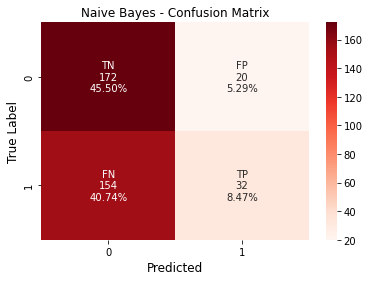

In [126]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('Naive Bayes - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)

## Two Headlines

In [142]:
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('clf', SVC()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [144]:
params = {'bow__ngram_range': [(1, 1), (1, 2)],
          'clf__C': (.1,1, 10, 100),
          'clf__gamma': (1, 0.1 , 0.01, 0.001),
          'clf__kernel': ('rbf', 'poly', 'sigmoid')}         

In [145]:
df_h = df[['Date','Label_1day','Top6','Top12']].copy()   
df_h['news'] = df_h['Top6']+df_h['Top12']
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label_1day']
y_test = test['Label_1day']

In [146]:
gs = GridSearchCV(estimator=nb_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['news'], y_train)

In [147]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'bow__ngram_range': (1, 1), 'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
accuracy: 0.5484441934249349


In [150]:
nb_pipe = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1, 1),analyzer=lambda x: x )),  
    ('tfidf', TfidfTransformer(use_idf=True) ),  
    ('classifier', SVC( C=1, gamma=1, kernel='rbf' )) ])

In [151]:
nb_pipe.fit(train['news'],y_train)
prediction = nb_pipe.predict(test['news'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.53      0.98      0.69       192
           1       0.84      0.11      0.20       186

    accuracy                           0.55       378
   macro avg       0.69      0.55      0.44       378
weighted avg       0.68      0.55      0.45       378

Accuracy: 0.5529100529100529


Text(0.5, 15.0, 'Predicted')

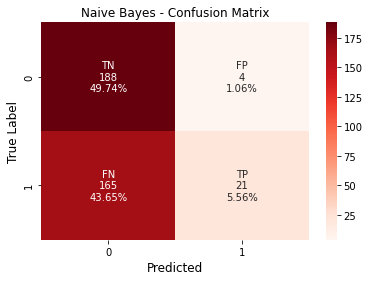

In [152]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('Naive Bayes - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)

## Three Headlines 

In [157]:
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('clf', SVC()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [213]:
params = {'bow__ngram_range': [(1, 1)],          
          'clf__gamma': (1,0.5,0.2),
          'clf__kernel': ('rbf','sigmoid')}  

In [214]:
df_h = df[['Date','Label','Top6','Top12','Top23']].copy()   
df_h['news'] = df_h['Top6']+df_h['Top12']+df_h['Top23']
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label']
y_test = test['Label']

In [215]:
gs = GridSearchCV(estimator=nb_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['news'], y_train)

In [216]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'bow__ngram_range': (1, 1), 'clf__gamma': 0.5, 'clf__kernel': 'rbf'}
accuracy: 0.5459689764576621


In [219]:
nb_pipe = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1, 1),analyzer=lambda x: x )),  
    ('tfidf', TfidfTransformer(use_idf=False)),  
    ('classifier', SVC(gamma=0.5, kernel='rbf')) ]) 

In [220]:
nb_pipe.fit(train['news'],y_train)
prediction = nb_pipe.predict(test['news'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.64      0.17      0.27       186
           1       0.53      0.91      0.67       192

    accuracy                           0.54       378
   macro avg       0.59      0.54      0.47       378
weighted avg       0.58      0.54      0.47       378

Accuracy: 0.544973544973545


Text(0.5, 15.0, 'Predicted')

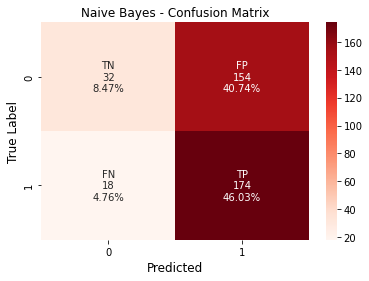

In [221]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('Naive Bayes - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)